## Load packages and set up notebook

In [11]:
# module load PyTorch/1.12.1-foss-2022a-CUDA-11.7.0
# module load torchvision/0.13.1-foss-2022a-CUDA-11.7.0
# module load scikit-learn/1.2.1-gfbf-2022b
# module load matplotlib/3.7.0-gfbf-2022b
# module load Seaborn/0.12.2-foss-2022b
# module load Boost.Python-NumPy/1.79.0-foss-2022a
# module load pandas/1.1.2-foss-2020a-Python-3.8.2
# module load Pillow/9.4.0-GCCcore-12.2.0
# module load tqdm/4.64.1-GCCcore-12.2.0
# pip install scikit-multilearn
# pip install torchmetrics

In [1]:
# packages
import os
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

from PIL import Image
from sklearn.metrics import f1_score
from sklearn.preprocessing import MultiLabelBinarizer
from skmultilearn.model_selection import iterative_train_test_split
from tqdm.notebook import tqdm

import torch
import torchvision.models as models
from torch.utils.data import Dataset, random_split, DataLoader
import torchvision.transforms as TF
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid

from torchmetrics import MeanMetric
from torchmetrics.classification import MultilabelF1Score

# constants
DATA_DIR = Path('./data/')
TRAIN_DIR, TEST_DIR = DATA_DIR / 'train', DATA_DIR / 'test'
TRAIN_CSV, TEST_CSV = DATA_DIR / 'train.csv', DATA_DIR / 'submission.csv'

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
NUM_CLASSES = 10
MEAN = torch.tensor([0.05409202, 0.05213123, 0.07833622])
STD = torch.tensor([0.39014456, 0.31953841, 0.36855768])

label_map = {
    0: 'Mitochondria',
    1: 'Nuclear bodies',
    2: 'Nucleoli',
    3: 'Golgi apparatus',
    4: 'Nucleoplasm',
    5: 'Nucleoli fibrillar center',
    6: 'Cytosol',
    7: 'Plasma membrane',
    8: 'Centrosome',
    9: 'Nuclear speckles',
}

# hyperparameters
RANDOM_SEED = 42
LEARNING_RATE = 0.001
BATCH_SIZE = 32
NUM_EPOCHS = 30
WEIGHT_DECAY = 0.0001
THRESHOLD = 0.35

TRANSFORM_TRAIN = TF.Compose([
    TF.RandomHorizontalFlip(),
    TF.RandomVerticalFlip(),
    TF.RandomRotation(180),
    TF.RandomResizedCrop(128, scale=(0.75, 1.0), ratio=(1.0, 1.0)),
    TF.RandomCrop(128, padding=4, padding_mode='reflect'),
    TF.ToTensor(),
    TF.Normalize(mean=MEAN, std=STD),
])
TRANSFORM_TEST = TF.Compose([
    TF.ToTensor(),
    TF.Normalize(mean=MEAN, std=STD),
])

sns.set_theme()
print('Using {} device'.format(DEVICE))

Using cpu device


## Helper functions

In [2]:
def encode_label(label):
    """
    Converts a label string into a one-hot encoded tensor
    """	
    target = torch.zeros(10)
    for l in str(label).split(' '):
        target[int(l)] = 1.
    return target

def decode_target(target, text_labels=False, threshold=0.5):
    """
    Converts a one-hot encoded tensor into a label string
    """
    result = []
    for i, x in enumerate(target):
        if (x >= threshold):
            if text_labels:
                result.append(label_map[i] + "(" + str(i) + ")")
            else:
                result.append(str(i))
    return ' '.join(result)

def show_sample(img, target, invert=True, threshold=0.5):
    """
    Displays a sample image and its labels
    """
    if invert:
        plt.imshow(1 - img.permute((1, 2, 0)))
    else:
        plt.imshow(img.permute(1, 2, 0))
    print('Labels:', decode_target(target, text_labels=True, threshold=threshold))

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(RANDOM_SEED)

## Load and split data

Number of labeled images: 15389 



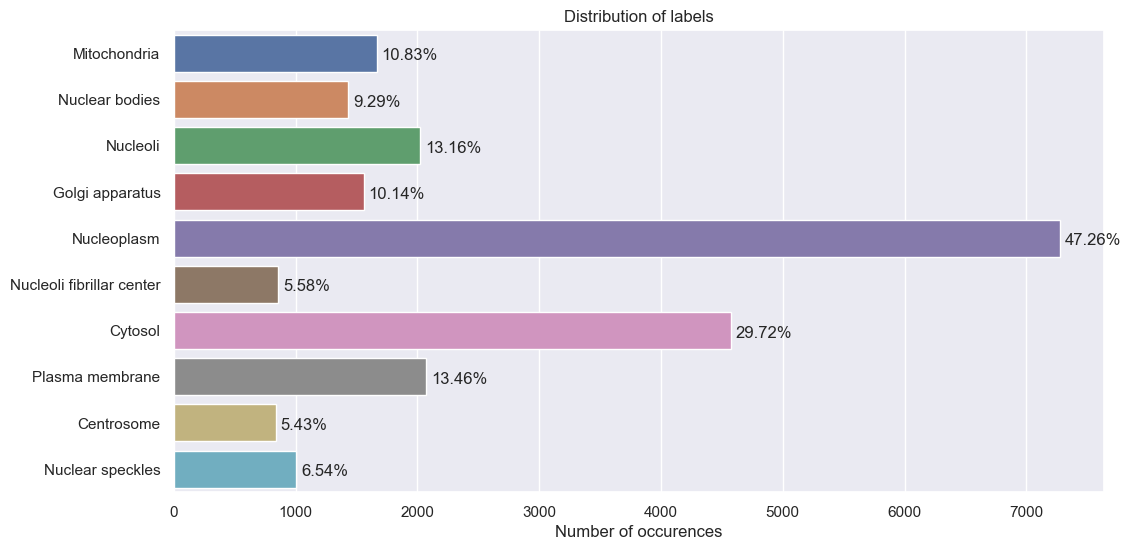

In [3]:
df = pd.read_csv(TRAIN_CSV)
print("Number of labeled images:", len(df), '\n')

# visualize class-imbalance
mlb = MultiLabelBinarizer()
counts = pd.DataFrame(
    mlb.fit_transform(df['Label'].apply(lambda x: x.split(' '))), 
    columns=mlb.classes_, index=df.index).sum()

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(
    # use label_map as x
    x=counts.values,
    y=[label_map[i] for i in range(10)],
    orient='h',
    hue=[label_map[i] for i in range(10)],
    ax=ax)
ax.set_title("Distribution of labels")
ax.set(xlabel="Number of occurences")
for i, v in enumerate(counts.values):
    ax.text(v + 40, i + .15, str(np.round(100 * v / len(df), 2)) + '%')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train samples      :  13856 	 72.03 %
Validation samples :  1533 	 7.97 %
Test samples       :  3847 	 20.0 % 

Example of a sample:
Labels: Nuclear bodies(1) Nucleoplasm(4)


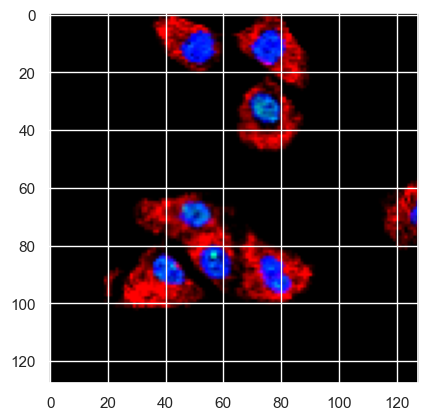

In [4]:
class HumanProteinDataset(Dataset):
    def __init__(self, X, y, root_dir, transform=None, weight_samples=False):
        self.df = pd.DataFrame({
            'Image': X.reshape(-1),
            'Label': [decode_target(l) for l in y]})
        self.transform = transform
        self.root_dir = root_dir
        
        if weight_samples:
            label_counts = y.sum(axis=0)
            label_weight = len(y) / (len(label_counts) * label_counts)
            label_weight = label_weight / label_weight.max()
            sample_weight = (y * label_weight).sum(axis=1) / y.sum(axis=1)
            self.sample_weights = torch.from_numpy(sample_weight)

    def __len__(self):
        return len(self.df)    
    
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_id, img_label = row['Image'], row['Label']
        img_fname = self.root_dir / (str(img_id) + ".png")
        img = Image.open(img_fname)
        if self.transform:
            img = self.transform(img)
        if hasattr(self, 'sample_weights'):
            return img, encode_label(img_label), self.sample_weights[idx]
        return img, encode_label(img_label)


# stratified split
X = df['Image']
y = pd.DataFrame(mlb.fit_transform(df['Label'].apply(lambda x: x.split(' '))), columns=mlb.classes_, index=df.index)
X_train, y_train, X_val, y_val = iterative_train_test_split(X.values.reshape(-1, 1), y.values, test_size=0.1)


# create datasets
train_ds = HumanProteinDataset(X_train, y_train, TRAIN_DIR, transform=TRANSFORM_TRAIN, weight_samples=True)
valid_ds = HumanProteinDataset(X_val, y_val, TRAIN_DIR, transform=TRANSFORM_TEST)
test_df = pd.read_csv(TEST_CSV)
test_ds = HumanProteinDataset(
    X = test_df['Image'].values.reshape(-1, 1), y = [[1] + [0] * 9] * len(test_df),
    root_dir = TEST_DIR, transform = TRANSFORM_TEST)


# create dataloaders
train_sampler = torch.utils.data.WeightedRandomSampler(train_ds.sample_weights, len(train_ds))
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=train_sampler)
valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)


# shows some statistics
tot_samples = len(train_ds) + len(valid_ds) + len(test_ds)
print("Train samples      : ", len(train_ds), '\t', np.round(100 * len(train_ds) / tot_samples, 2), '%')
print("Validation samples : ", len(valid_ds), '\t', np.round(100 * len(valid_ds) / tot_samples, 2), '%')
print("Test samples       : ", len(test_ds), '\t', np.round(100 * len(test_ds) / tot_samples, 2), '%', '\n')
print("Example of a sample:")
show_sample(train_ds[0][0], train_ds[0][1], invert=False)

In [5]:
class MultilabelImageClassificationBase(nn.Module):
    def training_step(self, batch, alpha):
        images, targets, weights = batch
        images, targets, weights = images.to(DEVICE), targets.to(DEVICE), weights.to(DEVICE)

        y_hat = self(images)                   
        loss = nn.BCEWithLogitsLoss()(y_hat, targets)
        
        weights_adjusted = alpha * weights + (1 - alpha)
        loss = (loss * weights_adjusted.unsqueeze(1)).mean()

        return loss

    def validation_step(self, batch):
        images, targets = batch 
        images, targets = images.to(DEVICE), targets.to(DEVICE)
        out = self(images)
        loss = nn.BCEWithLogitsLoss()(out, targets)
        score = MultilabelF1Score(num_labels=NUM_CLASSES, threshold=THRESHOLD, average='macro')(out, targets)
        return {'val_loss': loss.detach(), 'val_score': score.detach() }
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_scores = [x['val_score'] for x in outputs]
        epoch_score = torch.stack(batch_scores).mean()
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_score']))

class ProteinCnnModel(MultilabelImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),

            nn.Flatten(), 
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
            # nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.network(x)


model = ProteinCnnModel().to(DEVICE)
print("Number of parameters in the model :", sum(p.numel() for p in model.parameters() if p.requires_grad), '\n')


test_x = torch.randn(BATCH_SIZE, 3, 128, 128).to(DEVICE)
print('input.shape :', test_x.shape)
out = model(test_x)
print('out.shape   :', out.shape)
print('out[0]      :', [round(float(x), 3) for x in out[0]])

Number of parameters in the model : 614730 

input.shape : torch.Size([32, 3, 128, 128])
out.shape   : torch.Size([32, 10])
out[0]      : [-0.125, 0.127, 0.107, -0.073, -0.116, 0.009, -0.014, -0.003, -0.108, -0.003]


In [6]:
class SmallConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size = 3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, padding = "same"),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size, padding = "same"),
            nn.ReLU(),
            nn.MaxPool2d(2),
            )
    def forward(self, x):
        return self.net(x)

class BigConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size = 3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, padding = "same"),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size, padding = "same"),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size, padding = "same"),
            nn.ReLU(),
            nn.MaxPool2d(2),
            )
    def forward(self, x):
        return self.net(x)

class SmallResidualBlock(nn.Module):
    def __init__(self, channels = 64, kernel_size = 3):
        super().__init__()
        self.res1 = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size, padding = "same"),
            nn.BatchNorm2d(channels),
            nn.ReLU(),
            nn.Conv2d(channels, channels, kernel_size, padding = "same"),
            nn.BatchNorm2d(channels),
            )
        self.res2 = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size, padding = "same"),
            nn.BatchNorm2d(channels),
            nn.ReLU(),
            nn.Conv2d(channels, channels, kernel_size, padding = "same"),
            nn.BatchNorm2d(channels),
            )
    def forward(self, x):
        out1 = self.res1(x) + x
        out2 = self.res2(out1) + out1
        return out2
    
class BigResidualBlock(nn.Module):
    def __init__(self, channels = 64, kernel_size = 3):
        super().__init__()
        self.res1 = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size, padding = "same"),
            nn.BatchNorm2d(channels),
            nn.ReLU(),
            nn.Conv2d(channels, channels, kernel_size, padding = "same"),
            nn.BatchNorm2d(channels),
            )
        self.res2 = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size, stride=2),
            nn.BatchNorm2d(channels),
            )
        self.res3 = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size, padding = "same"),
            nn.BatchNorm2d(channels),
            nn.ReLU(),
            nn.Conv2d(channels, channels, kernel_size, padding = "same"),
            nn.BatchNorm2d(channels),
            )
    def forward(self, x):
        out1 = self.res1(x) + x
        out2 = self.res2(out1)
        out3 = self.res3(out2) + out2
        return out3

class PLCNN(MultilabelImageClassificationBase):
    def __init__(self):
        super(PLCNN, self).__init__()

        self.Rs_in = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),
            SmallResidualBlock(16, kernel_size=3),
            nn.MaxPool2d(2),
            )
        self.Ps_in = nn.Sequential(
            SmallConvBlock(3, 8, kernel_size=1),
            SmallConvBlock(8, 16, kernel_size=3),
            )
        
        self.Rl1 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=1),
            nn.ReLU(),
            BigResidualBlock(64, kernel_size=3),
            nn.ZeroPad2d((0, 1, 0, 1)),
            )
        self.Rl2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=1),
            nn.ReLU(),
            BigResidualBlock(256, kernel_size=3),
            nn.ZeroPad2d((0, 1, 0, 1)),
            )
        self.Rl3 = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=1),
            nn.ReLU(),
            BigResidualBlock(1024, kernel_size=3),
            nn.ZeroPad2d((0, 1, 0, 1)),
            )
        
        self.Pl1 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=1),
            nn.ReLU(),
            BigConvBlock(32, 64, kernel_size=3),
            )
        self.Pl2 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=1),
            nn.ReLU(),
            BigConvBlock(128, 256, kernel_size=3),
            )
        self.Pl3 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=1),
            nn.ReLU(),
            BigConvBlock(512, 1024, kernel_size=3),
            )
        
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(2048*4*4, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
            # nn.Sigmoid(),
        )

    def forward(self, x):
        # step 1
        out_rs = self.Rs_in(x)
        out_ps = self.Ps_in(x)
        # concat out_rs and out_ps
        out_1 = torch.cat((out_rs, out_ps), dim=1)
        
        # step 2
        out_rs = self.Rl1(out_1)
        out_ps = self.Pl1(out_1)
        # concat out_rs and out_ps
        out_2 = torch.cat((out_rs, out_ps), dim=1)

        # step 3
        out_rs = self.Rl2(out_2)
        out_ps = self.Pl2(out_2)
        # concat out_rs and out_ps
        out_3 = torch.cat((out_rs, out_ps), dim=1)

        # step 4
        out_rs = self.Rl3(out_3)
        out_ps = self.Pl3(out_3)
        # concat out_rs and out_ps
        out_4 = torch.cat((out_rs, out_ps), dim=1)

        # step 5
        out = self.head(out_4)

        return out
    
model = PLCNN().to(DEVICE)
print("Number of parameters in the model :", sum(p.numel() for p in model.parameters() if p.requires_grad), '\n')


test_x = torch.randn(BATCH_SIZE, 3, 128, 128).to(DEVICE)
print('input.shape :', test_x.shape)
out = model(test_x)
print('out.shape   :', out.shape)
print('out[0]      :', [round(float(x), 3) for x in out[0]])

Number of parameters in the model : 84780050 

input.shape : torch.Size([32, 3, 128, 128])
out.shape   : torch.Size([32, 10])
out[0]      : [0.054, -0.014, -0.039, 0.011, 0.039, 0.146, -0.002, 0.218, 0.127, 0.211]


In [7]:
class PreTrainedModel(MultilabelImageClassificationBase):
    def __init__(self, model):
        super(PreTrainedModel, self).__init__()

        self.backbone = model
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1000, 10),
            # nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.head(x)
        return x

model = PreTrainedModel(models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)).to(DEVICE)
print("Number of parameters in the efficientnet_b0 model :", sum(p.numel() for p in model.parameters() if p.requires_grad))
test_x = torch.randn(BATCH_SIZE, 3, 128, 128).to(DEVICE)
print('input.shape :', test_x.shape)
out = model(test_x)
print('out.shape   :', out.shape)
print('out[0]      :', [round(float(x), 3) for x in out[0]], '\n')

model = PreTrainedModel(models.resnet18(weights=models.ResNet18_Weights.DEFAULT)).to(DEVICE)
print("Number of parameters in the resnet18 model :", sum(p.numel() for p in model.parameters() if p.requires_grad))
test_x = torch.randn(BATCH_SIZE, 3, 128, 128).to(DEVICE)
print('input.shape :', test_x.shape)
out = model(test_x)
print('out.shape   :', out.shape)
print('out[0]      :', [round(float(x), 3) for x in out[0]], '\n')

model = PreTrainedModel(models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.DEFAULT)).to(DEVICE)
print("Number of parameters in the efficientnet_v2_s model :", sum(p.numel() for p in model.parameters() if p.requires_grad))
test_x = torch.randn(BATCH_SIZE, 3, 128, 128).to(DEVICE)
print('input.shape :', test_x.shape)
out = model(test_x)
print('out.shape   :', out.shape)
print('out[0]      :', [round(float(x), 3) for x in out[0]], '\n')

Number of parameters in the efficientnet_b0 model : 5298558
input.shape : torch.Size([32, 3, 128, 128])
out.shape   : torch.Size([32, 10])
out[0]      : [1.339, 0.384, -1.211, 0.649, 0.139, -0.414, -1.32, -0.898, -0.222, -0.355] 

Number of parameters in the resnet18 model : 11699522
input.shape : torch.Size([32, 3, 128, 128])
out.shape   : torch.Size([32, 10])
out[0]      : [0.849, -0.855, -0.166, 1.837, 0.689, 0.521, -0.512, 1.482, -0.72, -0.563] 

Number of parameters in the efficientnet_v2_s model : 21468498
input.shape : torch.Size([32, 3, 128, 128])
out.shape   : torch.Size([32, 10])
out[0]      : [0.589, -0.91, 0.187, 0.728, -0.009, 0.068, -0.386, 0.103, -0.574, -0.007] 



In [8]:
loss_fn = nn.BCEWithLogitsLoss(reduction='none')
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY, amsgrad=True)

In [9]:
# loss function, optimizer and scheduler
loss_fn = nn.BCEWithLogitsLoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3)

# Gradual transition parameters
start_epoch, end_epoch = 8, 16


def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader):
    torch.cuda.empty_cache()
    history = []
    for epoch in range(epochs):

        alpha = max(0.0, min(1.0, (i - start_epoch) / (end_epoch - start_epoch)))

        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            optimizer.zero_grad()
            loss = model.training_step(batch, alpha)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()

        scheduler.step(train_losses[-1])

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)

    return history

def plot_history(history):
    """
    Plots the train and validation loss and validation F1 score
    """
    train_losses = [x.get('train_loss') for x in history]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    val_losses = [x['val_loss'] for x in history]
    val_scores = [x['val_score'] for x in history]

    ax1.plot(train_losses, '-bx')
    ax1.plot(val_losses, '-rx')
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss')
    ax1.legend(['Training', 'Validation'])
    ax1.title.set_text('Loss vs. No. of epochs')

    ax2.plot(val_scores, '-rx')
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('F1 score')
    ax2.title.set_text('F1 score vs. No. of epochs')

In [10]:
CNN_model = ProteinCnnModel().to(DEVICE)
history_CNN = fit(NUM_EPOCHS, LEARNING_RATE, CNN_model, train_dl, valid_dl)

PLCNN_model = PLCNN().to(DEVICE)
history_PLCNN = fit(NUM_EPOCHS, LEARNING_RATE, PLCNN_model, train_dl, valid_dl)

EfficientNet_model = PreTrainedModel(models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)).to(DEVICE)
history_EfficientNet = fit(NUM_EPOCHS, LEARNING_RATE, EfficientNet_model, train_dl, valid_dl)

EfficientNetV2_model = PreTrainedModel(models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.DEFAULT)).to(DEVICE)
history_EfficientNetV2 = fit(NUM_EPOCHS, LEARNING_RATE, EfficientNetV2_model, train_dl, valid_dl)

ResNet_model = PreTrainedModel(models.resnet18(weights=models.ResNet18_Weights.DEFAULT)).to(DEVICE)
history_ResNet = fit(NUM_EPOCHS, LEARNING_RATE, ResNet_model, train_dl, valid_dl)

  0%|          | 0/433 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
plot_history(history_CNN)

In [ ]:
plot_history(history_PLCNN)

In [ ]:
plot_history(history_EfficientNet)

In [ ]:
plot_history(history_EfficientNetV2)

In [ ]:
plot_history(history_EfficientNetV2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction:  tensor([0.1531, 0.0974, 0.4670, 0.2802, 0.3611, 0.2472, 0.1331, 0.0174, 0.0290,
        0.0584], grad_fn=<SigmoidBackward0>)
Labels: Nucleoli(2) Nucleoplasm(4)


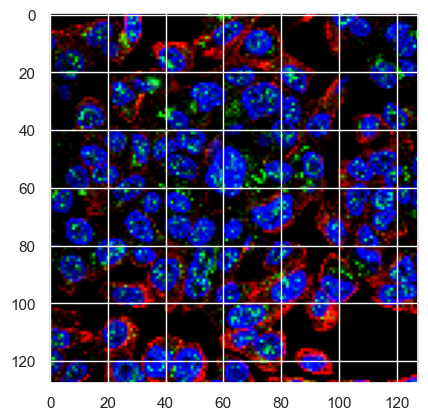

In [ ]:
def predict_single(image):
    x = image.unsqueeze(0)
    x = x.to(DEVICE)
    preds = model(x)
    prediction = nn.Sigmoid()(preds[0])
    print("Prediction: ", prediction)
    show_sample(image, prediction, invert=False, threshold=THRESHOLD)

predict_single(test_ds[100][0])

In [ ]:
def predict_dl(dl, model, threshold=0.5):
    model.eval()
    torch.cuda.empty_cache()
    batch_probs = []
    for x, _ in tqdm(dl):
        x = x.to(DEVICE)
        probs = model(x)
        batch_probs.append(probs.cpu().detach())
    print(torch.cat(batch_probs).shape)
    batch_probs = nn.Sigmoid()(torch.cat(batch_probs))
    return [decode_target(x, threshold=threshold) for x in batch_probs]

In [ ]:
def get_submission(model, dl, model_name="model"):
    test_preds = predict_dl(dl, model, threshold=THRESHOLD)
    submission_df = pd.read_csv(TEST_CSV)
    submission_df["Label"] = test_preds
    submission_df.to_csv("submission.csv", index=False)
    return submission_df

submission_CNN = get_submission(CNN_model, test_dl, model_name="CNN")
submission_PLCNN = get_submission(PLCNN_model, test_dl, model_name="PLCNN")
submission_EfficientNet = get_submission(EfficientNet_model, test_dl, model_name="EfficientNet")
submission_EfficientNetV2 = get_submission(EfficientNetV2_model, test_dl, model_name="EfficientNetV2")
submission_ResNet = get_submission(ResNet_model, test_dl, model_name="ResNet")

- Maybe try several thresholds and see which gives the best results score?
- Cross-validation and average the results? [here](https://www.kaggle.com/code/ronaldokun/multilabel-stratification-cv-and-ensemble)

In [ ]:
test_preds = predict_dl(test_dl, CNN_model, threshold=THRESHOLD)
submission_df = pd.read_csv(TEST_CSV)
submission_df["Label"] = test_preds
submission_df.head()

  0%|          | 0/121 [00:00<?, ?it/s]

torch.Size([3847, 10])


,Image,Label
0,25880,3
1,7810,6
2,23748,
3,24621,6 7
4,30169,


In [ ]:
submission_df.to_csv('submission.csv', index=False)